In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import zipfile

In [4]:
zf = zipfile.ZipFile('train0328.csv.zip')
df_train = pd.read_csv(zf.open('train0328.csv'),low_memory=False)
zf = zipfile.ZipFile('test0428.csv.zip')
df_test = pd.read_csv(zf.open('test0428.csv'),low_memory=False)

In [5]:
df_train.set_index('cust_code',inplace=True)
df_test.set_index('cust_code',inplace=True)

In [6]:
df_train = df_train.sample(frac=0.01)
df_test = df_test.sample(frac=0.01)
#train_idx = df_train.index
#df_test.loc[df_train.index]

In [7]:
df_train.columns

Index(['Unnamed: 0', 'fetch_date', 'emp_index', 'country', 'sex', 'age',
       'cust_date', 'new_cust', 'cust_seniority', 'indrel',
       'last_date_as_primary', 'cust_type', 'cust_rel', 'residence_index',
       'foreigner_index', 'joining_channel', 'deceased', 'prov_code',
       'prov_name', 'activity_index', 'income', 'segmentation',
       'savings_account', 'guarantees', 'current_account',
       'derivative_account', 'payroll_account', 'junior_account',
       'mas_account', 'perticular_account', 'perticular_plus', 'st_deposit',
       'mt_deposits', 'lt_deposits', 'e_account', 'funds', 'mortgage',
       'pension', 'loan', 'tax', 'credit_card', 'securities', 'home_account',
       'payroll', 'pension2', 'direct_debit', 'new_credit_card',
       'next_credit_card'],
      dtype='object')

In [8]:
dropping = ['cust_date','Unnamed: 0','prov_code','joining_channel','indrel','emp_index','new_cust','cust_type','residence_index','foreigner_index']

In [211]:
from preprocess_pca import preprocess_PCA

In [215]:
def preprocess_PCA(Xs,y):
    
    #defining the pipes 
    
    obj_Xs = Xs.drop(columns=['age','cust_seniority']).columns.tolist()
    num_Xs = ['age','cust_seniority']

    numeric_pipe = Pipeline(steps=[
        ('imputing mean', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler())
    ])

    categorical_pipe = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore',sparse=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('categorical',categorical_pipe,obj_Xs)
    ])

    postprocessor = ColumnTransformer(transformers=[
        ('numerical',numeric_pipe,num_Xs)
    ])
    
    #one-hot encoding the data
    Xs = preprocessor.fit_transform(Xs)
    
    #splitting the data
    from sklearn.model_selection import train_test_split
    train_Xs, test_Xs, train_y, test_y = train_test_split(Xs,
                                                          y,
                                                          test_size=0.4,
                                                          random_state=0)
    
    #impute the missing values
    train_Xs = impute_means(train_Xs)
    test_Xs = impute_means(test_Xs)
    
    #conducting pca
    from sklearn.decomposition import PCA
    pca = PCA(.95)
    pca.fit(train_Xs)
    train_Xs = pca.transform(train_Xs)
    test_Xs = pca.transform(test_Xs)
    
    #impute ys
    """
    Note this is a huristic that is not necessarily correct
    """
    train_y = train_y.fillna(0)
    test_y = test_y.fillna(0)
    
    return train_Xs, test_Xs, train_y, test_y

def impute_means(a):
    import numpy as np
    col_mean = np.nanmean(a, axis=0)
    idxs = np.where(np.isnan(a))
    a[idxs] = np.take(col_mean, idxs[1])
    return a

In [9]:
df_train.head()

full_train_Xs = df_train.drop(columns='next_credit_card')
full_train_y = df_train.loc[:,'next_credit_card']

final_test_Xs = df_test.drop(columns='next_credit_card')
final_test_y = df_train.loc[:,'next_credit_card']

full_train_Xs.drop(columns=dropping,inplace=True)
final_test_Xs.drop(columns=dropping,inplace=True)

In [216]:
train_Xs, test_Xs, train_y, test_y = preprocess_PCA(full_train_Xs,full_train_y)

interior splitting

Train/Test split and preprocessing

Standardizing the data and running PCA

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Identifying categorical vs numerical columns

Then making a data cleaning pipeline

In [17]:
obj_Xs = full_train_Xs.drop(columns=['age','cust_seniority']).columns.tolist()
num_Xs = ['age','cust_seniority']

numeric_pipe = Pipeline(steps=[
    ('imputing mean', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore',sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('categorical',categorical_pipe,obj_Xs)
])

postprocessor = ColumnTransformer(transformers=[
    ('numerical',numeric_pipe,num_Xs)
])

Defining PCA procedure; note: the reason why we need to conduct PCA is to
1. reduce the dimentionality of the data
2. re-introduce continuity into the data due to an extreme number of binary variables

In [18]:
full_train_Xs_pc = preprocessor.fit_transform(full_train_Xs)
final_test_Xs_pc = preprocessor.fit_transform(final_test_Xs)

In [19]:
from sklearn.model_selection import train_test_split
train_Xs, test_Xs, train_y, test_y = train_test_split(full_train_Xs_pc,
                                                      full_train_y,
                                                      test_size=0.4,
                                                      random_state=0)

In [ ]:
test_Xs.shape

(3701, 7145)

In [26]:
def impute_means(a):
    col_mean = np.nanmean(a, axis=0)
    idxs = np.where(np.isnan(a))
    a[idxs] = np.take(col_mean, idxs[1])
    return a

In [27]:
train_Xs = impute_means(train_Xs)
test_Xs = impute_means(test_Xs)

In [28]:
train_Xs.shape

(5550, 7145)

In [29]:
test_Xs.shape

(3701, 7145)

PCA

In [30]:
from sklearn.decomposition import PCA
pca = PCA(.95) #keeping 95% of all variance

In [31]:
pca.fit(train_Xs)

PCA(n_components=0.95)

In [32]:
print(f"train_Xs shape: {train_Xs.shape} ||| test_Xs shape: {test_Xs.shape}")

train_Xs shape: (5550, 7145) ||| test_Xs shape: (3701, 7145)


In [33]:
train_Xs = pca.transform(train_Xs)
test_Xs = pca.transform(test_Xs)

In [34]:
print(f"train_Xs shape: {train_Xs.shape} ||| test_Xs shape: {test_Xs.shape}")

train_Xs shape: (5550, 2682) ||| test_Xs shape: (3701, 2682)


In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [37]:
train_y.shape

(5550,)

In [38]:
train_y = train_y.fillna(0)
test_y = test_y.fillna(0)

In [39]:
pd.Series(train_Xs.ravel()).isna().any()

False

In [218]:
logisticRegr.fit(train_Xs, train_y)

LogisticRegression()

In [231]:
from sklearn.metrics import mean_absolute_error

preds_proba = logisticRegr.predict_proba(test_Xs)[:,0]
print(preds_proba)
preds = np.where(preds_proba<0.5,0,1)

[0.99968845 0.9998607  0.99986316 ... 0.99626709 0.99095497 0.99987055]


In [ ]:
maes = list()
scores = list()

for cutoff in np.linspace(0,1,15):
    preds = np.where(preds_proba<cutoff,0,1)
    print(f'with cutoff {cutoff},')
    mae = mean_absolute_error(test_y,preds)
    score = logisticRegr.score(test_Xs,test_y)
    print(f'the model has \n\tScore of: {score}\n\tMAE of: {mae}\n\n')
    maes.append((cutoff,mae))
    scores.append((cutoff,scores))

In [224]:
def get_confusion_mtx(df):
    from sklearn.metrics import confusion_matrix
    y_actu = df.loc[:,'true values']
    y_pred = df.loc[:,'predicted values']
    
    return confusion_matrix(y_actu,y_pred)

In [228]:
def graph_preds(validation,prediction):
    y_valid_ser = pd.Series(validation.reshape(1,-1)[0]).rename('true values')
    compare_df = pd.DataFrame(pd.Series(prediction).rename('predicted values')).join(y_valid_ser)
    
    confusion_mtx = get_confusion_mtx(compare_df)
    confusion_mtx = np.around(confusion_mtx/compare_df.shape[0],4)*100
    
    
    #adding jitters to the dataframe
    rows = compare_df.shape[0]
    compare_df = compare_df.apply(lambda x: x+np.random.randn(rows)*0.05)
    
    
    compare_df.plot.scatter(x='predicted values',
                            y='true values',
                            s=0.2)
    
    plt.xlim((-0.5,1.5))
    plt.ylim((-0.5,1.5))
    plt.xticks(range(0,2))
    plt.yticks(range(0,2))
    
    plt.text(0-0.3,1.3,f'False Negatives: {round(confusion_mtx[1,0],2)}%')#pred,actual
    plt.text(0-0.3,0.3,f'True Negatives: {round(confusion_mtx[0,0],2)}%')
    plt.text(1-0.3,0.3,f'False Positives: {round(confusion_mtx[0,1],2)}%')
    plt.text(1-0.3,1.3,f'True Positives: {round(confusion_mtx[1,1],2)}%')
    
    #plt.plot([-2,2],[-2,2],c='red',ls='--')
    plt.plot([0.5,0.5],[-0.5,1.5],c='black')
    plt.plot([-0.5,1.5],[0.5,0.5],c='black')
    
    plt.title('Scatterplot Representation of Logistic Confusion Matrix') 
    
    #display(compare_df)

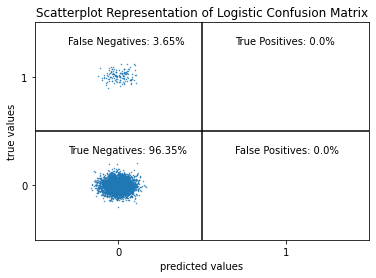

In [229]:
graph_preds(np.array(test_y),np.array(preds))

In [237]:
preds.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

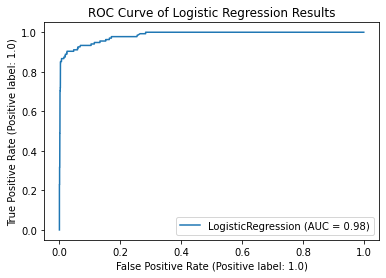

In [235]:
from sklearn import metrics
metrics.plot_roc_curve(logisticRegr, test_Xs, test_y)
plt.title('ROC Curve of Logistic Regression Results')
plt.show()

In [ ]:
full_outcomes = raw_df.loc[:,'savings_account':'new_direct_debit']

In [ ]:
outcomes = raw_df.loc[:,'savings_account':'direct_debit']

In [ ]:
new_outcomes = raw_df.loc[:,'new_savings_account':'new_direct_debit']

In [ ]:
full_outcomes = full_outcomes.fillna(full_outcomes.mean())

In [ ]:
income_X = raw_df.loc[:,'income'].rename('income')

In [ ]:
Xs = raw_df.drop(columns='income')

In [ ]:
def get_heatmap(df):
    fig, ax = plt.subplots(figsize=(15,12))
    sns.heatmap(df.corr(),ax=ax)
    plt.show()

In [ ]:
get_heatmap(full_outcomes.corr()) # white bars come from singleton responses (ie everyone responded with 0 or 1)

From this preliminary analysis, we are able to see that 

1. current_account is negatively correlated with payroll and derivative_account.
2. There are certain "product mixes" in the pooled sample. Meaning that if an indiviudal has a pension account, it is likely that they will also have a home_account, loans, and morgage accounts.
3. having a payroll_account this period is associated with a higher chance of getting a new_home_account and new_credit_card.
4. there are autocorrelations between account openings. If there are more account A opened this month, there is a higher than random chance that more of the same type of account will also be opened in the next period
5. If people have a current credit card, there will be a higher than random chance that they will get a new credit card in the next period
6. credit_cards and tax accounts are positively correlated with new pension and payroll accounts. Potentially signaling that if individuals income changes, they would begin to purchase more financial products.

In [ ]:
credit_card = raw_df.credit_card

In [ ]:
cc_t = raw_df.groupby('fetch_date')['credit_card'].mean().rename('t')
cc_t1 = cc_t.shift(1)

In [ ]:
ser = cc_t - cc_t1

In [ ]:
ser.plot()

In [ ]:
cc_t1

In [ ]:
pd.DataFrame(cc_t).join(cc_t1)

In [ ]:
credit_card.shift(1)

In [ ]:
def get_uniques(df):
    for col in df:
        print(f'{col} has values: {df[col].value_counts()}')
        print(f'{col} has {df[col].isna().sum()} NAs')
        print('---000---000---')

### Can we use fiancial products to reversely explain income?

In [ ]:
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
def transform_y(y):
    return numeric_pipe.fit_transform(np.array(y).reshape(-1, 1))

In [ ]:
def split_col_types(Xs):
    #Xs.describe(include=object).T #13 object classes
    #obj_Xs = Xs.describe(include=object).T.index.tolist()
    obj_Xs = Xs.drop(columns=['age','cust_seniority']).columns.tolist()
    #num_Xs = X_train.select_dtypes(include='number').columns.tolist()
    num_Xs = ['age','cust_seniority']
    
    return num_Xs, obj_Xs

In [ ]:
def construct_lasso_estimator(alpha,processor):
    from sklearn.linear_model import Lasso
    from sklearn.metrics import mean_absolute_error

    lasso = Lasso(alpha=alpha)

    lasso_pipe = Pipeline(steps=[
        ('preprocess',processor),
        ('model',lasso)
    ])

In [ ]:
def score_model(X_train, X_valid, y_train, y_valid):
    
    print(X_train.columns)
    
    y_train_colvec = transform_y(y_train)
    y_valid_colvec = transform_y(y_valid)

    fitted_lasso = lasso_pipe.fit(X_train,y_train_colvec)
    preds = lasso_pipe.predict(X_valid)

    mae = mean_absolute_error(y_valid_colvec,preds)
    score = lasso_pipe.score(X_valid,y_valid_colvec)

    print(f'the model has \n\tScore of: {score}\n\tMAE of: {mae}')

In [ ]:
def run_model(frac=0.1,alpha=1e-3,graphing=True):
    
    #defining a subsample to run tests, 1 if include all
    n_df = raw_df.sample(frac=frac)
    
    #splitting the independent variables and the y variables
    Xs = n_df.drop(columns=['income','Unnamed: 0','cust_code'],axis=1)
    y = n_df.income

    #train-test split
    X_train, X_valid, y_train, y_valid = train_test_split(Xs, 
                                                          y, 
                                                          test_size=.3,
                                                          random_state=1029)
    
    obj_Xs = Xs.drop(columns=['age','cust_seniority']).columns.tolist()
    num_Xs = ['age','cust_seniority']

    numeric_pipe = Pipeline(steps=[
        ('imputing mean', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler())
    ])

    categorical_pipe = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore',sparse=False))
    ])

    processor = ColumnTransformer(transformers=[
        ('numerical',numeric_pipe,num_Xs),
        ('categorical',categorical_pipe,obj_Xs)
    ])
    
    #
    
    from sklearn.linear_model import Lasso
    from sklearn.metrics import mean_absolute_error

    lasso = Lasso(alpha=alpha)

    lasso_pipe = Pipeline(steps=[
        ('preprocess',processor),
        ('model',lasso)
    ])
    
    #
    
    y_train_colvec = transform_y(y_train)
    y_valid_colvec = transform_y(y_valid)

    fitted_lasso = lasso_pipe.fit(X_train,y_train_colvec)
    preds = lasso_pipe.predict(X_valid)

    mae = mean_absolute_error(y_valid_colvec,preds)
    score = lasso_pipe.score(X_valid,y_valid_colvec)

    print(f'the model has \n\tScore of: {score}\n\tMAE of: {mae}')
    
    print(num_Xs)
    print(obj_Xs)
    #construct_lasso_estimator(alpha, processor)
    #score_model(X_train, X_valid, y_train, y_valid)
    if graphing:
        graph_preds(y_valid_colvec,preds)
        get_top_features(lasso_pipe,obj_Xs,num_Xs)

In [ ]:
run_model(frac=0.5,alpha=1e-6)

In [ ]:
run_model(frac=0.5,alpha=1e-6)

1. Select a few important features (X), and plot it against (y)
2. Then look at the interaction between Xs (X_1, X_2)
3. Outliers, visualization, overfitting, feature selection, preprocessing steps

Prove that there is no temporal link

If classification -> 0.8
If regression -> depends lol

Train and test has to be classified 

In [ ]:
def get_top_features(lasso_pipe,obj_Xs,num_Xs):
    
    #get the categorical names
    cat_colnames = lasso_pipe.named_steps['preprocess'].transformers_[1][1]\
       .named_steps['one_hot'].get_feature_names(obj_Xs).tolist()
    
    #creating list of all features
    all_cols = np.concatenate([num_Xs,cat_colnames])
    
    #creating coefficient plot for important features
    coef = lasso_pipe.named_steps['model'].coef_.flatten()
    coef_df = pd.DataFrame(zip(all_cols, coef), columns=["feature", "coef"])
    coef_df["abs_coef"] = coef_df["coef"].apply(lambda x: abs(x))
    coef_df["colors"] = coef_df["coef"].apply(lambda x: "green" if x > 0 else "red")
    coef_df = coef_df.sort_values("abs_coef", ascending=False)
    
    #graphing important features
    # Plot coef
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(x="feature",
                y="coef",
                data=coef_df.head(20),
               palette=coef_df.head(20)["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title("Top 20 Features", fontsize=25)
    ax.set_ylabel("Coef", fontsize=22)
    ax.set_xlabel("Feature Name", fontsize=22)

In [ ]:
cat_colnames = lasso_pipe.named_steps['preprocess'].transformers_[1][1]\
   .named_steps['one_hot'].get_feature_names(obj_Xs).tolist()

In [ ]:
all_cols = np.concatenate([num_Xs,cat_colnames])

In [ ]:
len(all_cols)

In [ ]:
len(cat_colnames)

In [ ]:
coef = lasso_pipe.named_steps['model'].coef_.flatten()

In [ ]:
coef_df = pd.DataFrame(zip(all_cols, coef), columns=["feature", "coef"])

In [ ]:
coef_df["abs_coef"] = coef_df["coef"].apply(lambda x: abs(x))
coef_df["colors"] = coef_df["coef"].apply(lambda x: "green" if x > 0 else "red")
coef_df = coef_df.sort_values("abs_coef", ascending=False)

cust_code, prov_code, activity_index, segmentation needs to be converted to categorical

In [ ]:
num_Xs

In [ ]:
# Plot coef
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="coef",
            data=coef_df.head(20),
           palette=coef_df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [ ]:
importance = np.abs(coef)
np.array(Xs.columns)[importance>0]

In [ ]:
np.count_nonzero(importance)

### Pipeline Building

### Construct Lasso Estimator

In [ ]:
graph_preds(y_valid_colvec,preds)